# Set-Up and Imports

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import surrojax_gp
import oed_toolbox
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import sys
sys.path.insert(0, '..')
import plotting_helpers
import computation_helpers

Save directory for figures:

In [2]:
fig_save_dir = './figs'
if not os.path.isdir(fig_save_dir):
    os.makedirs(fig_save_dir)

Random seed:

In [3]:
jax_rng = jax.random.PRNGKey(42)

Load our surrogate:

In [4]:
beam_gp = surrojax_gp.load_gp('../chapter_4/nonlinear_beam_gp.json')

# Training of Amortised Distributions

Defining our prior and joint:

In [5]:
noise_cov = 0.005*jnp.identity(1)
prior_cov = 0.01*jnp.identity(1)
prior_mean = 0.5*jnp.ones((1,))
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
beam_model = oed_toolbox.models.Model.from_surrojax_gp(beam_gp)
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
joint = oed_toolbox.distributions.Joint.from_prior_and_likelihood(prior, likelihood)

## Reverse KL Approximation

In [6]:
max_iter = 200
num_samples = 1000
y_lims = (0.0, 1.0)
d_lims = (0.0, 1.0)
num_y_pts = num_d_pts = 10
num_layers = 5
nn_width = 10
activation = 'tanh'
phi_lims = {'mean': {'lb':-0.25, 'ub':1.25}, 'log_chol_diag': {'lb':-3, 'ub':-2.}}
t_start = time.time()
reverse_approx, reverse_loss = \
computation_helpers.train_nn_amortised_normal_approx(beam_gp, y_lims, d_lims, num_y_pts, num_d_pts, 
                                                     noise_cov, prior_mean, prior_cov, 
                                                     jax_rng, num_samples, max_iter,
                                                     num_layers, nn_width, activation, phi_lims,
                                                     loss_name='reverse_kl', use_reparameterisation=True,
                                                     verbose=False)
t_reverse_train = time.time() - t_start
print(f'Took {t_reverse_train:.2f} seconds to train Reverse KL amortised approximation.')

Took 67.67 seconds to train Reverse KL amortised approximation.


Let's now save the weights of this trained approximation

In [8]:
# reverse_approx.save('reverse_kl_approx')

Let's now plot the surface of the mean and variance of our approximation:

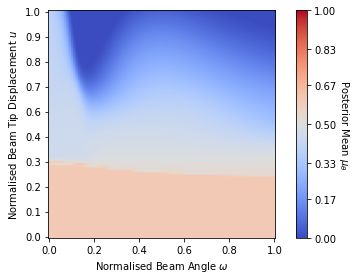

In [7]:
num_y_pts = num_d_pts = 100
mpl.rcParams.update(mpl.rcParamsDefault)
fig = plotting_helpers.plot_amortised_phi(reverse_approx, y_lims, d_lims, num_y_pts, num_d_pts, 'mean', phi_ticks_dp=2)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'reverse_kl_mean.pdf'), bbox_inches='tight')
plt.show()

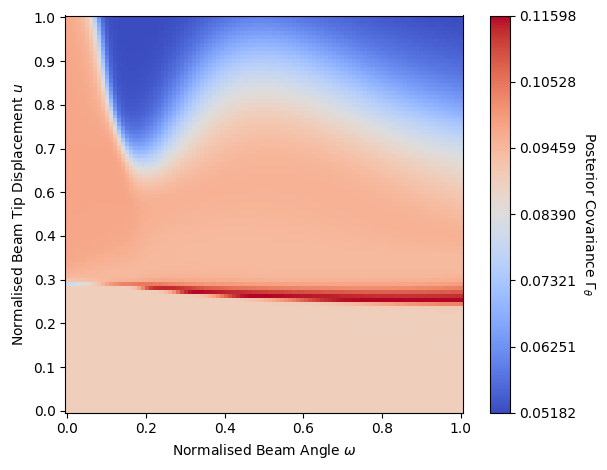

In [8]:
num_y_pts = num_d_pts = 100
mpl.rcParams.update(mpl.rcParamsDefault)
fig = plotting_helpers.plot_amortised_phi(reverse_approx, y_lims, d_lims, num_y_pts, num_d_pts,
                                          'log_chol_diag', phi_ticks_dp=5)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'reverse_kl_variance.pdf'), bbox_inches='tight')
plt.show()

Let's also plot the loss history:

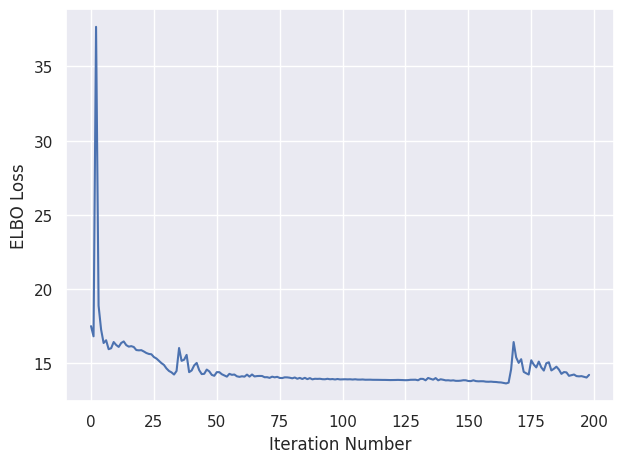

In [9]:
sns.set_theme(style='darkgrid')
fig = plotting_helpers.plot_loss_history(reverse_loss, y_label='ELBO Loss')
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'reverse_kl_loss.pdf'), bbox_inches='tight')
plt.show()

## Forward KL Training

In [10]:
max_iter = 200
num_samples = 1000
y_lims = (0.0, 1.0)
d_lims = (0.0, 1.0)
num_y_pts = num_d_pts = 10
num_layers = 5
nn_width = 10
activation = 'tanh'
phi_lims = {'mean': {'lb':-0.25, 'ub':1.25}, 'log_chol_diag': {'lb':-3, 'ub':-2.}}
t_start = time.time()
forward_approx, forward_loss = \
computation_helpers.train_nn_amortised_normal_approx(beam_gp, y_lims, d_lims, num_y_pts, num_d_pts, 
                                                     noise_cov, prior_mean, prior_cov, 
                                                     jax_rng, num_samples, max_iter,
                                                     num_layers, nn_width, activation, phi_lims,
                                                     loss_name='forward_kl', use_reparameterisation=False,
                                                     verbose=False)
t_forward_train = time.time() - t_start
print(f'Took {t_forward_train:.2f} seconds to train Forward KL amortised approximation.')

Took 88.18 seconds to train Forward KL amortised approximation.


Saving these trained weights:

In [13]:
# forward_approx.save('forward_kl_approx')

Once again, let's plot the mean and variance surfaces:

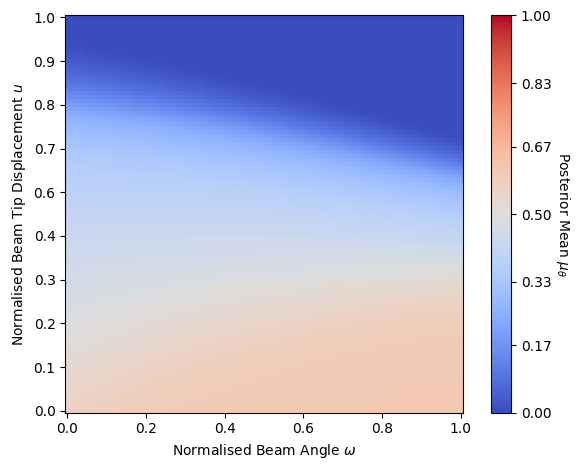

In [14]:
num_y_pts = num_d_pts = 100
mpl.rcParams.update(mpl.rcParamsDefault)
fig = plotting_helpers.plot_amortised_phi(forward_approx, y_lims, d_lims, num_y_pts, num_d_pts, 'mean', phi_ticks_dp=2)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'forward_kl_mean.pdf'), bbox_inches='tight')
plt.show()

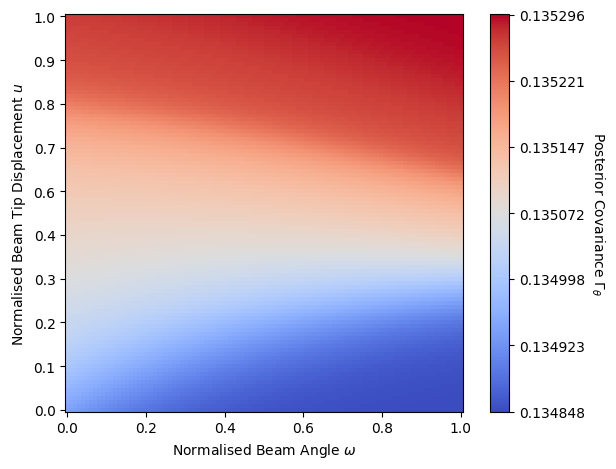

In [15]:
num_y_pts = num_d_pts = 100
mpl.rcParams.update(mpl.rcParamsDefault)
fig = plotting_helpers.plot_amortised_phi(forward_approx, y_lims, d_lims, num_y_pts, num_d_pts, 
                                          'log_chol_diag', phi_ticks_dp=6)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'forward_kl_variance.pdf'), bbox_inches='tight')
plt.show()

Plotting the loss history:

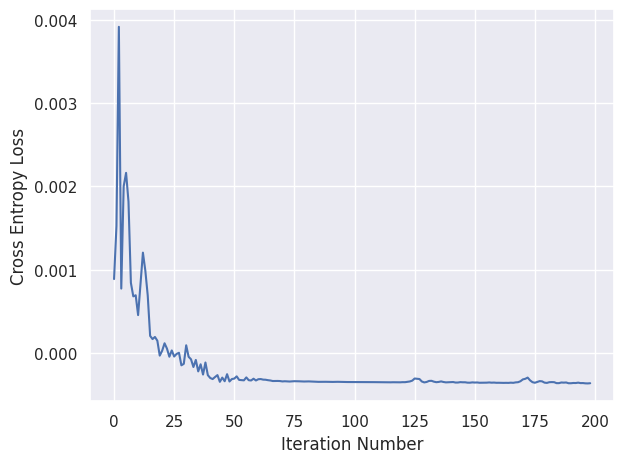

In [16]:
sns.set_theme(style='darkgrid')
fig = plotting_helpers.plot_loss_history(forward_loss, y_label='Cross Entropy Loss')
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'forward_kl_loss.pdf'), bbox_inches='tight')
plt.show()